In [1]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import csv

In [2]:
#matplotlib function that will plot the graphs
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
def open_and_read(industry):
    time_step = []
    cases = []
    with open(f'../final industry csvs/{industry}.csv') as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      next(reader)
      steps = 0
      for row in reader:
        cases.append(float(row[-1]))
        time_step.append(steps)
        steps+=1

    series = np.array(cases)
    time = np.array(time_step)
    plt.figure(figsize=(10, 6))
    plot_series(time, series)
    
    return series, time

In [6]:
def steps_split(split, industry):
    split_time = split
    series, time = open_and_read(industry)
    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]
    
    return time_train, x_train, time_valid, x_valid

In [7]:
def create_model(shuffle, window, batch, epochs, split, industry):
    time_train, x_train, time_valid, x_valid = steps_split(split, industry)
    shuffle_buffer_size = shuffle
    window_size = window
    batch_size = batch
    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    model_central = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    #stochastic gradient descent used for optimization
    optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

    #compile using huber loss and mean absolute error
    model_central.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history_central = model_central.fit(train_set, epochs=epochs)
    model_central.save(f"../models/industries/lstm-model-{industry}-industry.h5")
    return history_central, model_central

In [8]:
shuffle_buffer_size = 10
window_size = 5
batch_size = 5
epochs = 300
split = 10

Epoch 1/300
1/1 [==============================] - 0s 82ms/step - loss: 4.4519 - mae: 4.9502
Epoch 2/300
1/1 [==============================] - 0s 5ms/step - loss: 4.4519 - mae: 4.9502
Epoch 3/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4519 - mae: 4.9502
Epoch 4/300
1/1 [==============================] - 0s 5ms/step - loss: 4.4518 - mae: 4.9501
Epoch 5/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4518 - mae: 4.9501
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4517 - mae: 4.9501
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4517 - mae: 4.9500
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4516 - mae: 4.9499
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4516 - mae: 4.9499
Epoch 10/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4515 - mae: 4.9498
Epoch 11/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4514

1/1 [==============================] - 0s 997us/step - loss: 4.4423 - mae: 4.9414
Epoch 90/300
1/1 [==============================] - 0s 997us/step - loss: 4.4422 - mae: 4.9413
Epoch 91/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4421 - mae: 4.9412
Epoch 92/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4420 - mae: 4.9411
Epoch 93/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4419 - mae: 4.9410
Epoch 94/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4417 - mae: 4.9409
Epoch 95/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4416 - mae: 4.9408
Epoch 96/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4415 - mae: 4.9407
Epoch 97/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4414 - mae: 4.9406
Epoch 98/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4413 - mae: 4.9404
Epoch 99/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4412 

1/1 [==============================] - 0s 997us/step - loss: 4.4325 - mae: 4.9321
Epoch 176/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4324 - mae: 4.9320
Epoch 177/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4323 - mae: 4.9319
Epoch 178/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4322 - mae: 4.9318
Epoch 179/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4321 - mae: 4.9317
Epoch 180/300
1/1 [==============================] - 0s 4ms/step - loss: 4.4320 - mae: 4.9316
Epoch 181/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4319 - mae: 4.9315
Epoch 182/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4318 - mae: 4.9314
Epoch 183/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4317 - mae: 4.9313
Epoch 184/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4316 - mae: 4.9312
Epoch 185/300
1/1 [==============================] - 0s 2ms/step - loss:

1/1 [==============================] - 0s 3ms/step - loss: 4.4244 - mae: 4.9243
Epoch 263/300
1/1 [==============================] - 0s 913us/step - loss: 4.4243 - mae: 4.9242
Epoch 264/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4242 - mae: 4.9241
Epoch 265/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4241 - mae: 4.9240
Epoch 266/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4240 - mae: 4.9240
Epoch 267/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4240 - mae: 4.9239
Epoch 268/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4239 - mae: 4.9238
Epoch 269/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4238 - mae: 4.9237
Epoch 270/300
1/1 [==============================] - 0s 2ms/step - loss: 4.4237 - mae: 4.9236
Epoch 271/300
1/1 [==============================] - 0s 3ms/step - loss: 4.4236 - mae: 4.9235
Epoch 272/300
1/1 [==============================] - 0s 4ms/step - loss:

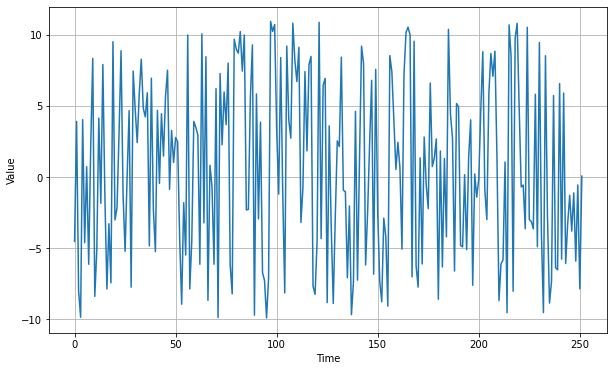

In [10]:
industry = 'Agriculture'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, industry)

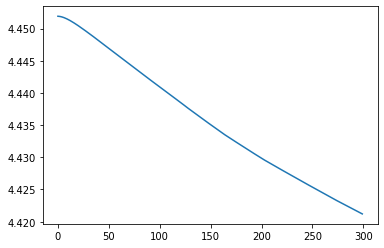

In [11]:
plt.plot(history_central.history['loss'])

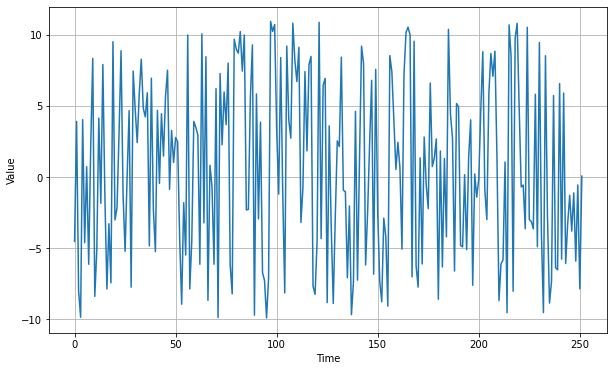

In [12]:
series, time = open_and_read(industry)

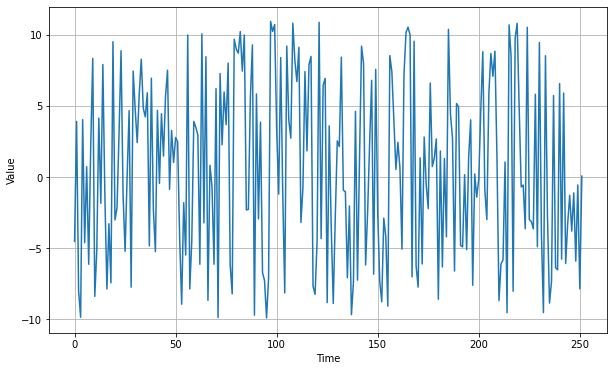

In [13]:
time_train, x_train, time_valid, x_valid = steps_split(split, industry)

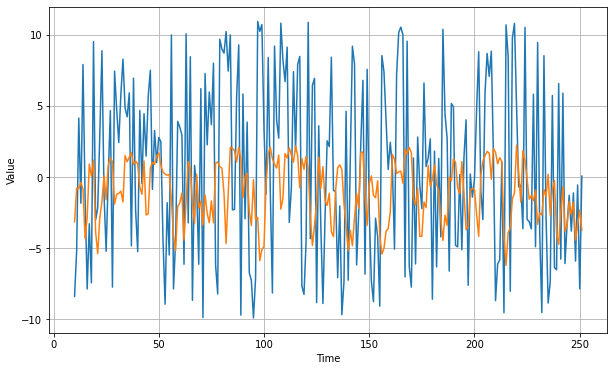

In [14]:
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 25ms/step - loss: 8.9118 - mae: 9.4080
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 8.9062 - mae: 9.4024
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 8.8957 - mae: 9.3916
Epoch 4/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8807 - mae: 9.3764
Epoch 5/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8619 - mae: 9.3570
Epoch 6/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8393 - mae: 9.3340
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8136 - mae: 9.3076
Epoch 8/300
1/1 [==============================] - 0s 3ms/step - loss: 8.7855 - mae: 9.2787
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 8.7550 - mae: 9.2473
Epoch 10/300
1/1 [==============================] - 0s 3ms/step - loss: 8.7226 - mae: 9.2138
Epoch 11/300
1/1 [==============================] - 0s 3ms/step - loss: 8.6884

1/1 [==============================] - 0s 4ms/step - loss: 6.3739 - mae: 6.8739
Epoch 90/300
1/1 [==============================] - 0s 3ms/step - loss: 6.3556 - mae: 6.8556
Epoch 91/300
1/1 [==============================] - 0s 3ms/step - loss: 6.3374 - mae: 6.8374
Epoch 92/300
1/1 [==============================] - 0s 3ms/step - loss: 6.3194 - mae: 6.8194
Epoch 93/300
1/1 [==============================] - 0s 2ms/step - loss: 6.3016 - mae: 6.8016
Epoch 94/300
1/1 [==============================] - 0s 3ms/step - loss: 6.2839 - mae: 6.7839
Epoch 95/300
1/1 [==============================] - 0s 3ms/step - loss: 6.2663 - mae: 6.7663
Epoch 96/300
1/1 [==============================] - 0s 2ms/step - loss: 6.2489 - mae: 6.7489
Epoch 97/300
1/1 [==============================] - 0s 3ms/step - loss: 6.2315 - mae: 6.7315
Epoch 98/300
1/1 [==============================] - 0s 2ms/step - loss: 6.2141 - mae: 6.7141
Epoch 99/300
1/1 [==============================] - 0s 3ms/step - loss: 6.1966 - ma

1/1 [==============================] - 0s 3ms/step - loss: 5.2965 - mae: 5.7964
Epoch 177/300
1/1 [==============================] - 0s 4ms/step - loss: 5.2899 - mae: 5.7899
Epoch 178/300
1/1 [==============================] - 0s 3ms/step - loss: 5.2834 - mae: 5.7834
Epoch 179/300
1/1 [==============================] - 0s 4ms/step - loss: 5.2769 - mae: 5.7769
Epoch 180/300
1/1 [==============================] - 0s 3ms/step - loss: 5.2704 - mae: 5.7704
Epoch 181/300
1/1 [==============================] - 0s 2ms/step - loss: 5.2640 - mae: 5.7640
Epoch 182/300
1/1 [==============================] - 0s 3ms/step - loss: 5.2576 - mae: 5.7576
Epoch 183/300
1/1 [==============================] - 0s 3ms/step - loss: 5.2511 - mae: 5.7511
Epoch 184/300
1/1 [==============================] - 0s 3ms/step - loss: 5.2449 - mae: 5.7449
Epoch 185/300
1/1 [==============================] - 0s 3ms/step - loss: 5.2386 - mae: 5.7386
Epoch 186/300
1/1 [==============================] - 0s 2ms/step - loss: 5

1/1 [==============================] - 0s 2ms/step - loss: 4.7797 - mae: 5.2719
Epoch 264/300
1/1 [==============================] - 0s 2ms/step - loss: 4.7748 - mae: 5.2665
Epoch 265/300
1/1 [==============================] - 0s 3ms/step - loss: 4.7699 - mae: 5.2612
Epoch 266/300
1/1 [==============================] - 0s 1ms/step - loss: 4.7650 - mae: 5.2558
Epoch 267/300
1/1 [==============================] - 0s 2ms/step - loss: 4.7602 - mae: 5.2505
Epoch 268/300
1/1 [==============================] - 0s 2ms/step - loss: 4.7554 - mae: 5.2452
Epoch 269/300
1/1 [==============================] - 0s 3ms/step - loss: 4.7506 - mae: 5.2400
Epoch 270/300
1/1 [==============================] - 0s 3ms/step - loss: 4.7458 - mae: 5.2347
Epoch 271/300
1/1 [==============================] - 0s 3ms/step - loss: 4.7412 - mae: 5.2295
Epoch 272/300
1/1 [==============================] - 0s 3ms/step - loss: 4.7366 - mae: 5.2243
Epoch 273/300
1/1 [==============================] - 0s 1ms/step - loss: 4

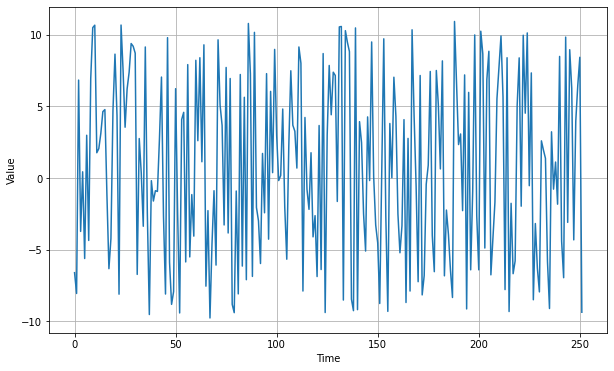

In [15]:
industry = 'Banking_and_Finance'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, industry)

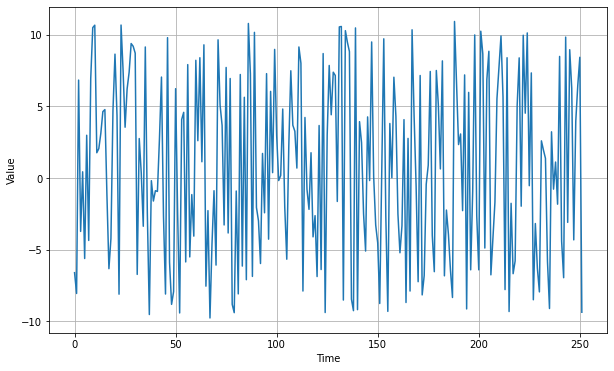

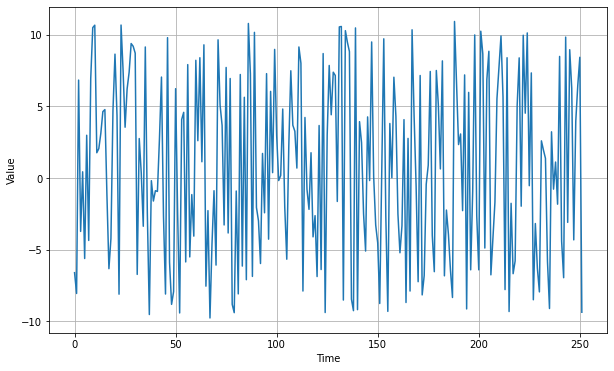

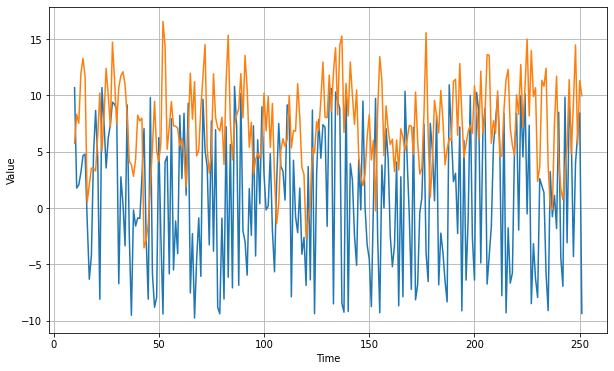

In [16]:
series, time = open_and_read(industry)
time_train, x_train, time_valid, x_valid = steps_split(split, industry)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Epoch 1/300
1/1 [==============================] - 0s 22ms/step - loss: 9.6239 - mae: 10.1098
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 9.6226 - mae: 10.1084
Epoch 3/300
1/1 [==============================] - 0s 3ms/step - loss: 9.6201 - mae: 10.1057
Epoch 4/300
1/1 [==============================] - 0s 4ms/step - loss: 9.6166 - mae: 10.1019
Epoch 5/300
1/1 [==============================] - 0s 3ms/step - loss: 9.6122 - mae: 10.0971
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 9.6070 - mae: 10.0914
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 9.6010 - mae: 10.0849
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 9.5944 - mae: 10.0776
Epoch 9/300
1/1 [==============================] - 0s 4ms/step - loss: 9.5872 - mae: 10.0697
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 9.5795 - mae: 10.0613
Epoch 11/300
1/1 [==============================] - 0s 3ms/step - lo

1/1 [==============================] - 0s 4ms/step - loss: 8.8717 - mae: 9.3717
Epoch 90/300
1/1 [==============================] - 0s 4ms/step - loss: 8.8646 - mae: 9.3646
Epoch 91/300
1/1 [==============================] - 0s 2ms/step - loss: 8.8574 - mae: 9.3574
Epoch 92/300
1/1 [==============================] - 0s 2ms/step - loss: 8.8502 - mae: 9.3502
Epoch 93/300
1/1 [==============================] - 0s 4ms/step - loss: 8.8430 - mae: 9.3430
Epoch 94/300
1/1 [==============================] - 0s 2ms/step - loss: 8.8357 - mae: 9.3357
Epoch 95/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8285 - mae: 9.3285
Epoch 96/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8213 - mae: 9.3213
Epoch 97/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8140 - mae: 9.3140
Epoch 98/300
1/1 [==============================] - 0s 3ms/step - loss: 8.8065 - mae: 9.3065
Epoch 99/300
1/1 [==============================] - 0s 3ms/step - loss: 8.7992 - ma

1/1 [==============================] - 0s 4ms/step - loss: 8.2452 - mae: 8.7452
Epoch 177/300
1/1 [==============================] - 0s 3ms/step - loss: 8.2379 - mae: 8.7379
Epoch 178/300
1/1 [==============================] - 0s 2ms/step - loss: 8.2305 - mae: 8.7305
Epoch 179/300
1/1 [==============================] - 0s 3ms/step - loss: 8.2232 - mae: 8.7232
Epoch 180/300
1/1 [==============================] - 0s 4ms/step - loss: 8.2160 - mae: 8.7160
Epoch 181/300
1/1 [==============================] - 0s 4ms/step - loss: 8.2089 - mae: 8.7089
Epoch 182/300
1/1 [==============================] - 0s 3ms/step - loss: 8.2018 - mae: 8.7018
Epoch 183/300
1/1 [==============================] - 0s 3ms/step - loss: 8.1947 - mae: 8.6947
Epoch 184/300
1/1 [==============================] - 0s 4ms/step - loss: 8.1876 - mae: 8.6876
Epoch 185/300
1/1 [==============================] - 0s 3ms/step - loss: 8.1805 - mae: 8.6805
Epoch 186/300
1/1 [==============================] - 0s 3ms/step - loss: 8

1/1 [==============================] - 0s 2ms/step - loss: 7.6394 - mae: 8.1394
Epoch 264/300
1/1 [==============================] - 0s 3ms/step - loss: 7.6323 - mae: 8.1323
Epoch 265/300
1/1 [==============================] - 0s 3ms/step - loss: 7.6253 - mae: 8.1253
Epoch 266/300
1/1 [==============================] - 0s 2ms/step - loss: 7.6182 - mae: 8.1182
Epoch 267/300
1/1 [==============================] - 0s 5ms/step - loss: 7.6112 - mae: 8.1112
Epoch 268/300
1/1 [==============================] - 0s 3ms/step - loss: 7.6042 - mae: 8.1042
Epoch 269/300
1/1 [==============================] - 0s 3ms/step - loss: 7.5971 - mae: 8.0971
Epoch 270/300
1/1 [==============================] - 0s 2ms/step - loss: 7.5901 - mae: 8.0901
Epoch 271/300
1/1 [==============================] - 0s 4ms/step - loss: 7.5830 - mae: 8.0830
Epoch 272/300
1/1 [==============================] - 0s 3ms/step - loss: 7.5760 - mae: 8.0760
Epoch 273/300
1/1 [==============================] - 0s 4ms/step - loss: 7

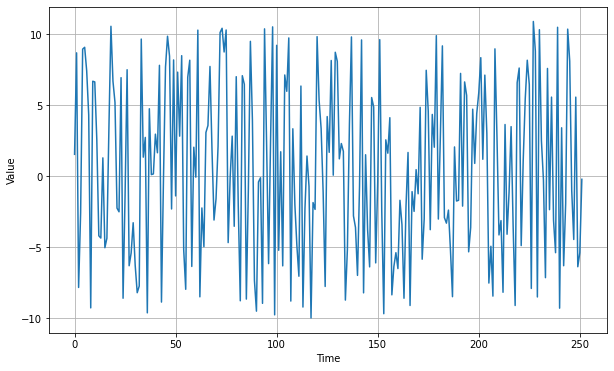

In [17]:
industry = 'Food_Production__Distribution'
history_central, model_central = create_model(shuffle_buffer_size, window_size, batch_size, epochs, split, industry)

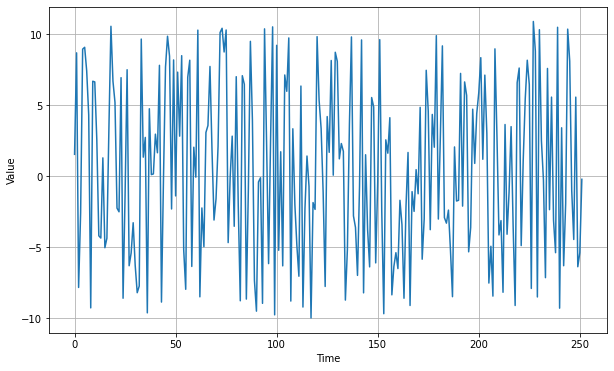

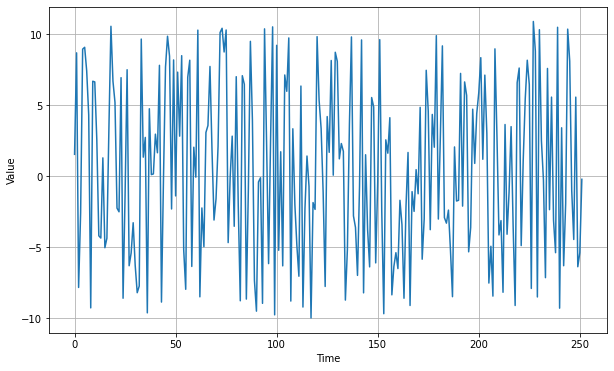

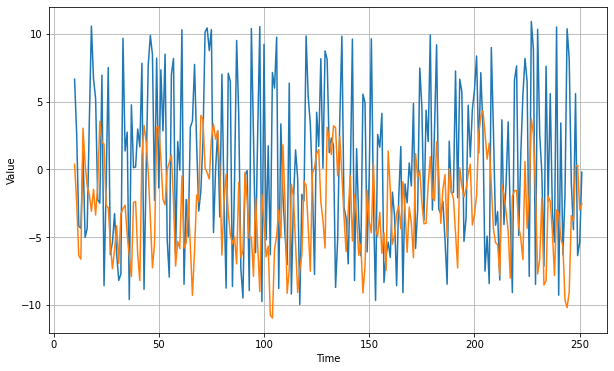

In [18]:
series, time = open_and_read(industry)
time_train, x_train, time_valid, x_valid = steps_split(split, industry)
rnn_forecast = model_forecast(model_central, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)